# Part 2 - Data Analysis

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import pyodbc
import warnings
import numpy as np
import matplotlib.transforms as mtrans
warnings.filterwarnings('ignore')
import scipy.stats as stats 

In [2]:
def DBconnect(username):
    conn = pyodbc.connect('DRIVER={SQL Server};'
                          'SERVER=technionddscourse.database.windows.net;'
                          f'DATABASE={username};'
                          f'UID={username};'
                          'PWD=Password')
    cursor = conn.cursor()
    return cursor, conn

cursor, conn = DBconnect("Username")

<center>In our analysis we will look into multiple aspects of possible causes of Precipitation. <br>
First, we will look into the affects of geospatial data on precipitation throughout Germany and Sweden.</center>

In [3]:
query = "SELECT * FROM StationData"
stationData = pd.read_sql(query, conn)
stationData.head(5)

,StationId,Latitude,Longitude,Elevation
0,SW000002120,66.9597,17.7300,314.0
1,GM000001153,51.9506,7.5914,62.0
2,SW000002127,65.0667,17.1664,325.0
3,GM000001474,53.1017,8.7842,4.0
4,GM000002277,49.7517,6.6467,144.0


The data we have available is coordinates of measuring stations along with their elevation. We will determine the affects of Elevation and Latitude on Precipitations levels.

In [4]:
query = "SELECT * FROM DataStore_Stage2"
stationData_temp = stationData.set_index('StationId')
df = pd.read_sql(query, conn).set_index('StationId')
complete_data = df.join(stationData_temp, how='left')
space_df = complete_data.drop(['Year_Rec','Month_Rec'], axis=1)
variables = ['PRCP','TMAX','TMIN','SNWD']
specs = ['Latitude', 'Longitude', 'Elevation']

# Geospatial Analysis
We will try to find some correlation between a stations elevation level and the amount of precipitation recoreded at that station.

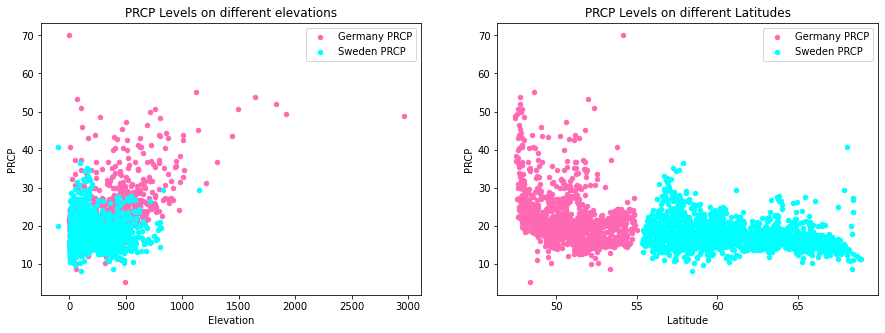

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
function_data = complete_data[['PRCP','Elevation']].dropna()
function_data = function_data.reset_index()
function_data.dropna(subset = ['PRCP'], inplace=True)
function_data = function_data.groupby(['StationId','Elevation']).mean()
function_data = function_data.reset_index()
function_data_ger = function_data[function_data.StationId.str.startswith("GM")].set_index('StationId')\
                                                                                .sort_values('Elevation')
function_data_swe = function_data[function_data.StationId.str.startswith("SW")].set_index('StationId')\
                                                                                .sort_values('Elevation')
function_data = function_data.set_index('StationId').sort_values('Elevation')
function_data_ger.plot(x = 'Elevation', y= 'PRCP', title = 'PRCP' + " Levels on different elevations",\
                                       color='hotpink', kind="scatter",ax=ax1, label = "Germany "+'PRCP')
function_data_swe.plot(x = 'Elevation', y= 'PRCP', title = 'PRCP' + " Levels on different elevations",\
                                       color='cyan', kind="scatter", ax=ax1, label = "Sweden "+'PRCP')

function_data2 = complete_data[['PRCP','Latitude']].dropna()
function_data2 = function_data2.reset_index()
function_data2.dropna(subset = ['PRCP'], inplace=True)
function_data2 = function_data2.groupby(['StationId','Latitude']).mean()
function_data2 = function_data2.reset_index()
function_data_ger2 = function_data2[function_data2.StationId.str.startswith("GM")].set_index('StationId')\
                                                                                    .sort_values('Latitude')
function_data_swe2 = function_data2[function_data2.StationId.str.startswith("SW")].set_index('StationId')\
                                                                                    .sort_values('Latitude')
function_data2 = function_data2.set_index('StationId').sort_values('Latitude')
function_data_ger2.plot(x = 'Latitude', y= 'PRCP', title = 'PRCP' + " Levels on different Latitudes",\
                                    color='hotpink', kind="scatter",ax=ax2, label = "Germany "+'PRCP')
function_data_swe2.plot(x = 'Latitude', y= 'PRCP', title = 'PRCP' + " Levels on different Latitudes",\
                                        color='cyan', kind="scatter", ax=ax2, label = "Sweden "+'PRCP')
plt.show()

<b>Elevation</b>: We can see from the scatter plots that both in Sweden and Germany most of the stations elevation range from 0-700 meters, with a few more located on 700+ meters. Also, we can see that the majority of the stations recored Precipitation levels ranging from 0-40 milliliters.<br>
<b>Latitude</b>: Germany and Sweden have no overlapping latitude coordinates so in the scatter plot we see that Germany samples and Sweden samples are seperable by latitude.<br>
### Germany - Initial Conclusions:
<ul>
  <li>Most of the stations elevation range from 0-1000 meters, with a few more located on 1000+ meters.</li>
  <li>Precipitation levels range from 0 to 50 with a few outliers ranging from 50+</li>
  <li>Precipitation in the southern part of Germany seems higher than the nothern part, but that could be explained by the difference in elevation between the two regions, as can be seen in the left scatter plot, stations with higher elevation ocasionally have higher precipitation.</li>

</ul> 

### Sweden - Initial Conclusions:
<ul>
  <li>Most of the stations elevation range from 0-600 meters, with a few more located on 600-700 meters.</li>
  <li>Precipitation levels range from 0 to 40 </li>
</ul> 
We will now try to determine if there is some sort of correlation between the variables and PRCP.


In [6]:
from scipy.stats import spearmanr, pearsonr
from numpy import cov
function_data
print('ELEVATION - PRCP')
corr, _ = pearsonr(function_data.PRCP, function_data.Elevation)
print('\tPearsons correlation: %.3f' % corr)
corr, _ = spearmanr(function_data.PRCP, function_data.Elevation)
print('\tSpearmans correlation: %.3f' % corr)
print('LATITUDE - PRCP')
corr, _ = pearsonr(function_data2.PRCP, function_data2.Latitude)
print('\tPearsons correlation: %.3f' % corr)
corr, _ = spearmanr(function_data2.PRCP, function_data2.Latitude)
print('\tSpearmans correlation: %.3f' % corr)

ELEVATION - PRCP
	Pearsons correlation: 0.459
	Spearmans correlation: 0.341
LATITUDE - PRCP
	Pearsons correlation: -0.459
	Spearmans correlation: -0.499


In both Elevation and Latitude, we see that there is no strong correlation (Both linear and Nonlinear), but there is some indication that the higher higher elevation and lower latitude could mean higher PRCP.<br>
We will look at a heat map to try to find evidence of that

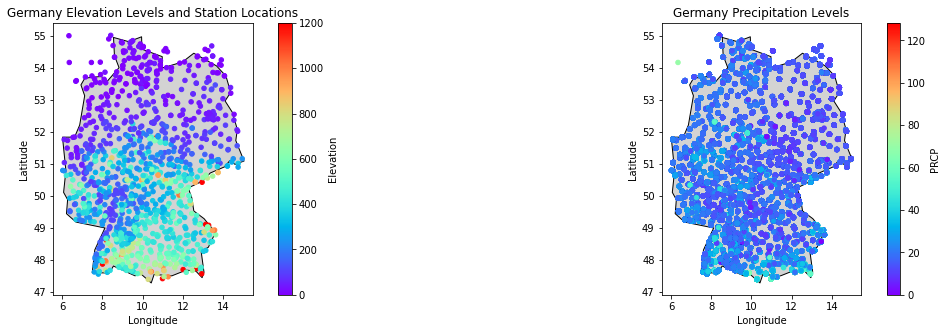

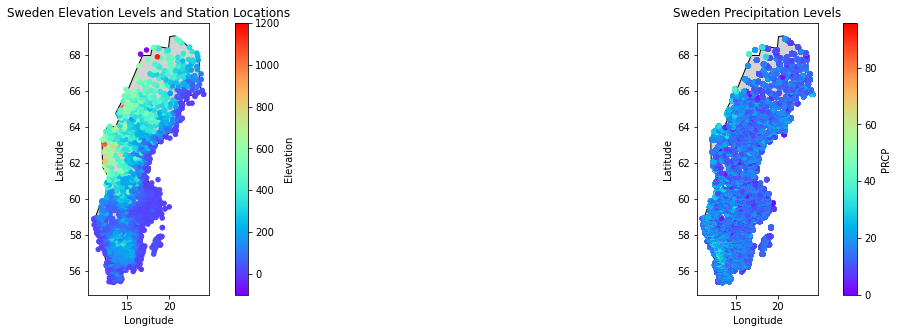

In [7]:
# Plot Germany
germany_df = stationData[stationData.StationId.str.startswith("GM")].reset_index()
geometry = [Point(xy) for xy in zip(germany_df['Longitude'], germany_df['Latitude'])]
gdf = GeoDataFrame(germany_df, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 5))
sub_germany = world.loc[world['name'].isin(["Germany"])]
sub_germany.plot(color="lightgrey", ax=ax1, edgecolor='k')
gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow', \
         title="Germany Elevation Levels and Station Locations", c='Elevation', ax=ax1, vmax= 1200)

germany_df = complete_data.filter(axis='index', regex = '^GM').reset_index()\
                .groupby(['StationId','Year_Rec']).mean().drop('Month_Rec',axis=1)
geometry = [Point(xy) for xy in zip(germany_df['Longitude'], germany_df['Latitude'])]
gdf = GeoDataFrame(germany_df, geometry=geometry)
sub_germany = world.loc[world['name'].isin(["Germany"])]
sub_germany.plot(color="lightgrey", edgecolor='k',ax=ax2)
gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow',\
                         title="Germany Precipitation Levels", c='PRCP',ax=ax2, legend=False)

# Plot Sweden
sweden_eu = stationData[stationData.StationId.str.startswith(tuple(["SW"]))].reset_index()
swed_geometry = [Point(xy) for xy in zip(sweden_eu['Longitude'], sweden_eu['Latitude'])]
sweden_eu_gdf = GeoDataFrame(sweden_eu, geometry=swed_geometry)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 5))
swed_plot = world.loc[world['name'].isin(["Sweden"])]
swed_plot.plot(color="lightgrey", edgecolor='k',ax=ax1)
sweden_eu_gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow',\
                    title="Sweden Elevation Levels and Station Locations", c='Elevation', ax=ax1,vmax = 1200)

sweden_eu = complete_data.filter(axis='index', regex = '^SW').reset_index().groupby(['StationId','Year_Rec'])\
                                                                            .mean().drop('Month_Rec',axis=1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
swed_geometry = [Point(xy) for xy in zip(sweden_eu['Longitude'], sweden_eu['Latitude'])]
sweden_eu_gdf = GeoDataFrame(sweden_eu, geometry=swed_geometry)
swed_plot = world.loc[world['name'].isin(["Sweden"])]
swed_plot.plot(color="lightgrey", edgecolor='k',ax=ax2)
sweden_eu_gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow',\
                                   title="Sweden Precipitation Levels", c='PRCP',
         ax=ax2, legend=False)

plt.show()

As can be seen, in both Germany and Sweden it seems that the lower the latitude and the higher the altitude, there seems to be a rise in precipitation, compared to other regions, although no definite signs of clear correlation

# Time Analysis
We will assess the effects of seasons on Precipitation and will search for some correlation between PRCP and a time variable

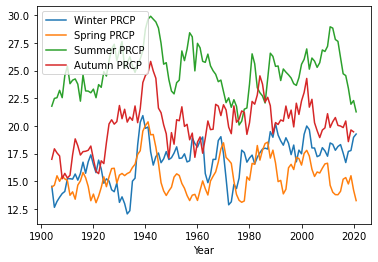

In [8]:
time_anls = complete_data.reset_index().drop(['Month_Rec','Latitude','Longitude','Elevation','TMAX','TMIN', 'SNWD'], axis=1).sort_values('Year_Rec').rename(columns={"Year_Rec":"Year"})
winter = time_anls.loc[time_anls['Season'].astype(int) == 1].drop(['Season', 'StationId'], axis=1)\
                                    .groupby('Year').mean().rename(columns={"PRCP": "Winter PRCP"})
spring = time_anls.loc[time_anls['Season'].astype(int) == 2].drop(['Season', 'StationId'], axis=1)\
                                    .groupby('Year').mean().rename(columns={"PRCP": "Spring PRCP"})
summer = time_anls.loc[time_anls['Season'].astype(int) == 3].drop(['Season', 'StationId'], axis=1)\
                                    .groupby('Year').mean().rename(columns={"PRCP": "Summer PRCP"})
autumn = time_anls.loc[time_anls['Season'].astype(int) == 4].drop(['Season', 'StationId'], axis=1)\
                                    .groupby('Year').mean().rename(columns={"PRCP": "Autumn PRCP"})
winter['Winter PRCP'] = winter['Winter PRCP'].rolling(5).mean()
spring['Spring PRCP'] = spring['Spring PRCP'].rolling(5).mean()
summer['Summer PRCP'] = summer['Summer PRCP'].rolling(5).mean()
autumn['Autumn PRCP'] = autumn['Autumn PRCP'].rolling(5).mean()
ax = winter.plot()
spring.plot(ax = ax)
summer.plot(ax = ax)
autumn.plot(ax = ax)
plt.legend()
plt.show()

This graph shows the rolling average of precipitation per season throughout the years 1900-2021.<br>
### Conclusions:
<ul>
  <li>Precipitation tends to be higher in the summer than the winter.</li>
  <li>In the past ~10 years there seems to be a sharp decline in precipitation in the summer time.</li>
  <li>Precipitation in the winter is pretty stable in the past 40 years.</li>
</ul> 

We will analyse the Maximun and Minimum Temperatures throughout the years, by season to help us make claims later in the analysis.

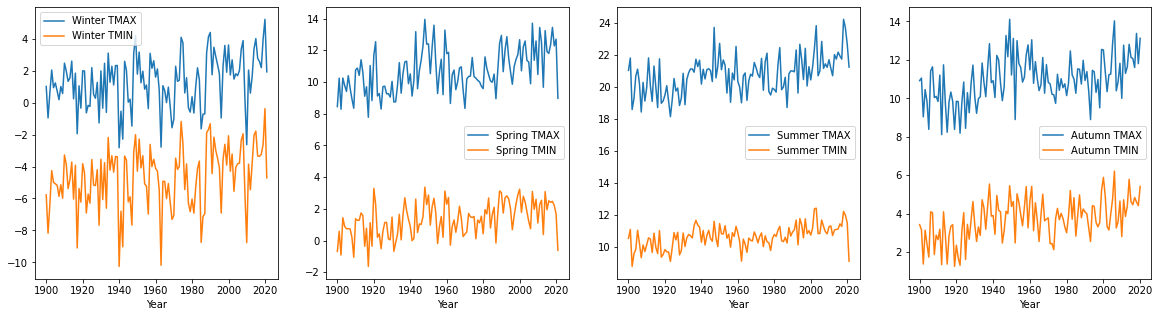

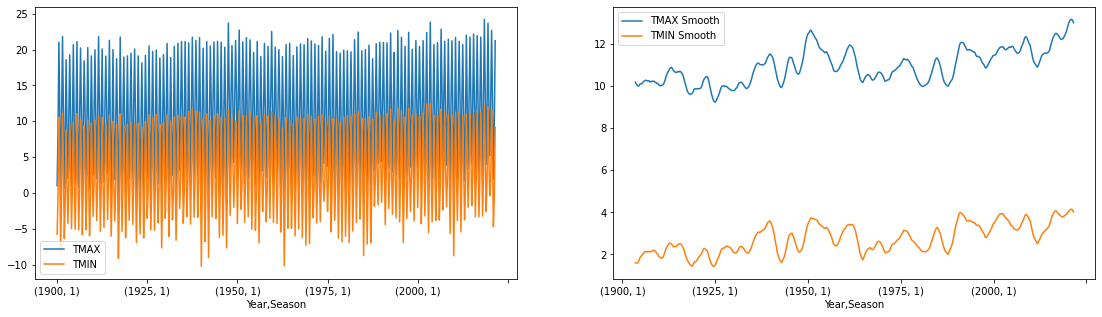

In [9]:
time_anls2 = complete_data.reset_index().drop(['Month_Rec','Latitude','Longitude','Elevation','PRCP','SNWD','StationId'], axis=1).sort_values('Year_Rec').rename(columns={"Year_Rec":"Year"})
winter = time_anls2.loc[time_anls2['Season'].astype(int) == 1].drop(['Season', ], axis=1)\
        .groupby('Year').mean().rename(columns={"TMAX": "Winter TMAX", "TMIN":"Winter TMIN"})
spring = time_anls2.loc[time_anls2['Season'].astype(int) == 2].drop(['Season'], axis=1)\
        .groupby('Year').mean().rename(columns={"TMAX": "Spring TMAX", "TMIN":"Spring TMIN"})
summer = time_anls2.loc[time_anls2['Season'].astype(int) == 3].drop(['Season'], axis=1)\
        .groupby('Year').mean().rename(columns={"TMAX": "Summer TMAX", "TMIN":"Summer TMIN"})
autumn = time_anls2.loc[time_anls2['Season'].astype(int) == 4].drop(['Season'], axis=1)\
        .groupby('Year').mean().rename(columns={"TMAX": "Autumn TMAX", "TMIN":"Autumn TMIN"})
time_anls2 = time_anls2.groupby(['Year','Season']).mean()
fig ,(ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,5))
total_reg = time_anls2.copy()
total_smooth = pd.DataFrame()
total_smooth['TMAX Smooth'] = total_reg['TMAX'].rolling(8).mean()
total_smooth['TMIN Smooth'] = total_reg['TMIN'].rolling(8).mean()
total_smooth['TMAX Smooth'] = total_smooth['TMAX Smooth'].rolling(8).mean()
total_smooth['TMIN Smooth'] = total_smooth['TMIN Smooth'].rolling(8).mean()
winter.plot(ax=ax1)
spring.plot(ax=ax2)
summer.plot(ax=ax3)
autumn.plot(ax=ax4)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(19,5))
total_reg.plot(ax=ax1)
total_smooth.plot(ax=ax2)
plt.legend()
plt.show()

Firstly, when look at a specific season we see that usually the minimum and maximum temperatures have similar trends, that is a year with a high maximum tempreture will have a high minimum tempreture and vice versa.<br>
Secondly, when looking at the temperatures over time (bottom plots) we can see that there is a slight upward trend in both minimum and maximum temperatures in the last ten years. Since we are relying in ice melting for most of our precipitation that could indicate that in the future we might see less ice forming in higher altitude areas to melt in the summer times.


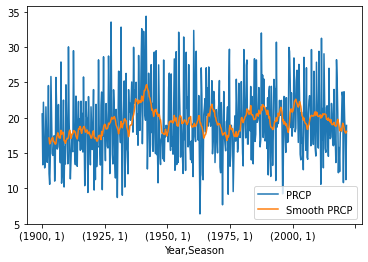

In [10]:
time_anls = complete_data.reset_index().drop(['Latitude','Longitude','Elevation','TMAX','TMIN', 'SNWD'], axis=1)\
                                                                            .rename(columns={"Year_Rec":"Year"})
time_anls['Season'] = (((time_anls['Month_Rec']%12)/3)+1).astype(int)
time_anls = time_anls.drop('Month_Rec',axis=1)
time_anls = time_anls.groupby(['Year','Season']).mean()
time_anls['Smooth PRCP'] = time_anls['PRCP'].rolling(12).mean()
time_anls.PRCP.plot(label = 'PRCP')
time_anls['Smooth PRCP'].plot(label = 'Smooth PRCP')
plt.legend()
plt.show()

Indeed when looking at the smoothed graph that represents trends in our data, we can see that over the last 10-15 years we see a slight decline in precipitation, when combining that with the fact that we saw that precipitation in summer has also dropped in the past 10 years while winter precipitation levels were stable we can speculate that a rise in temperatures could possibly be a reason for that.


# Time and Space Analysis

Lastly, We will assess the affects of both geospatial and Temporal dimensions on PRCP.<br>
We will look at a combination of elevation, longitude, latitude and season and their affect on PRCP.

In [11]:
time_anls = complete_data.reset_index().drop(['Month_Rec','Latitude','Longitude','Elevation','TMAX','TMIN'], axis=1).sort_values('Year_Rec').rename(columns={"Year_Rec":"Year"})
winter_anls = time_anls.loc[time_anls['Season'].astype(int) == 1].drop(['Year'], axis=1)\
                .groupby(['StationId','Season']).mean().rename(columns={"PRCP": "Winter PRCP","SNWD":"Winter SNWD"})
spring_anls = time_anls.loc[time_anls['Season'].astype(int) == 2].drop(['Year'], axis=1)\
                .groupby(['StationId','Season']).mean().rename(columns={"PRCP": "Spring PRCP","SNWD":"Spring SNWD"})
summer_anls = time_anls.loc[time_anls['Season'].astype(int) == 3].drop(['Year'], axis=1)\
                .groupby(['StationId','Season']).mean().rename(columns={"PRCP": "Summer PRCP","SNWD":"Summer SNWD"})
autumn_anls = time_anls.loc[time_anls['Season'].astype(int) == 4].drop(['Year'], axis=1)\
                .groupby(['StationId','Season']).mean().rename(columns={"PRCP": "Autumn PRCP","SNWD":"Autumn SNWD"})

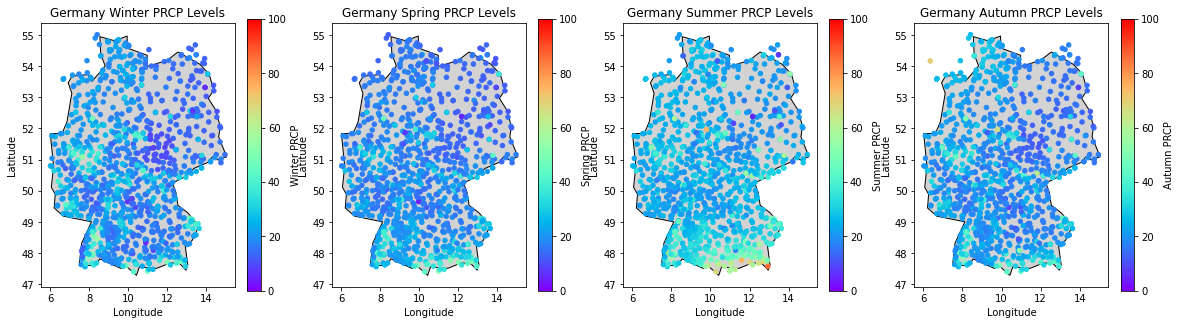

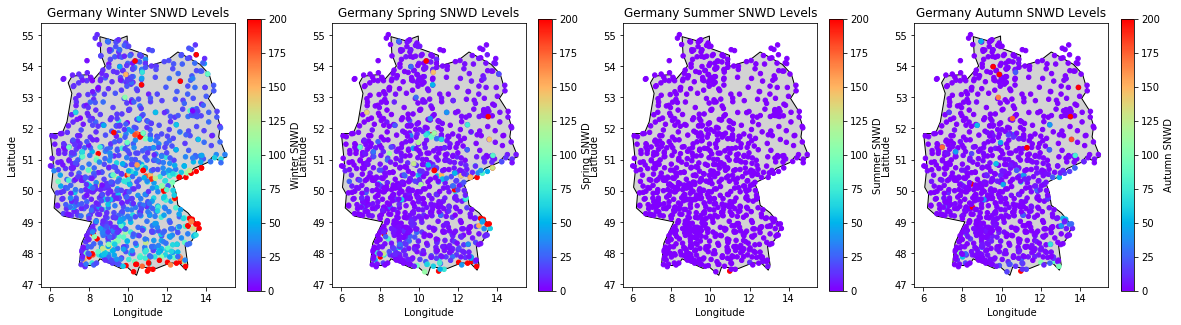

In [12]:
seasons = [winter_anls,spring_anls,summer_anls,autumn_anls]
PRCP_cols = ['Winter PRCP','Spring PRCP','Summer PRCP','Autumn PRCP']
SNWD_cols = ['Winter SNWD','Spring SNWD','Summer SNWD','Autumn SNWD']
fig, axarr = plt.subplots(1,4,figsize=(20, 5))
for axi,season,col in zip(axarr,seasons,PRCP_cols):
    germany_df = stationData[stationData.StationId.str.startswith("GM")].reset_index()\
                                .merge(season,left_on="StationId",right_on='StationId')
    geometry = [Point(xy) for xy in zip(germany_df['Longitude'], germany_df['Latitude'])]
    gdf = GeoDataFrame(germany_df, geometry=geometry)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    sub_germany = world.loc[world['name'].isin(["Germany"])]
    sub_germany.plot(color="lightgrey", ax=axi, edgecolor='k')
    gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow', title="Germany "+col+" Levels", c=col,
             ax=axi,vmin = 0,vmax = 100)
plt.show()
fig, axarr = plt.subplots(1,4,figsize=(20, 5))
for axi,season,col in zip(axarr,seasons,SNWD_cols):
    germany_df = stationData[stationData.StationId.str.startswith("GM")].reset_index()\
                                .merge(season,left_on="StationId",right_on='StationId')
    geometry = [Point(xy) for xy in zip(germany_df['Longitude'], germany_df['Latitude'])]
    gdf = GeoDataFrame(germany_df, geometry=geometry)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    sub_germany = world.loc[world['name'].isin(["Germany"])]
    sub_germany.plot(color="lightgrey", ax=axi, edgecolor='k')
    gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow', title="Germany "+col+" Levels", c=col,
             ax=axi,vmin = 0,vmax = 200)
plt.show()

### Germany Conclusions:
<ul>
    <li>Precipitation in the <i>Summer</i> is high in southern Germany, that could be explained by ice melting from the Alpes and flowing north.</li>
    <li>Precipitation in the <i>Autumn</i> is similar to that of the summer but in smaller volumes, the leftover ice is melting in southern germany and rain has began to cover the north-western part of Germany.</li>
    <li>Precipitation in the <i>Winter</i> is relatively high in the north-western part of Germany on all latitutes. </li>
    <li> Precipitation in the <i>Spring</i> is the lowest of all the seasons, most likely do to low rain and low tempratures keeping the ice in the alpes from melting.</li>
</ul>

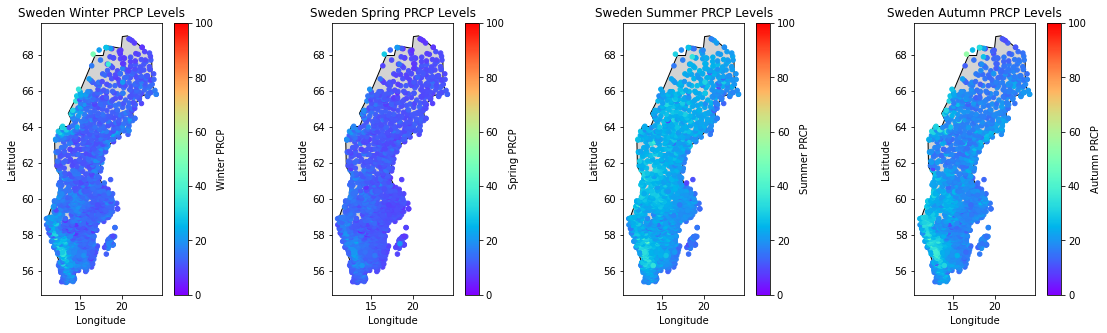

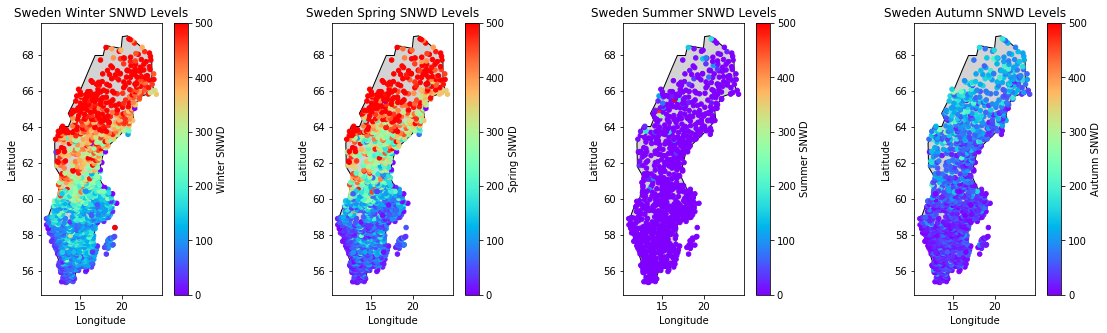

In [13]:
seasons = [winter_anls,spring_anls,summer_anls,autumn_anls]
fig, axarr = plt.subplots(1,4,figsize=(20, 5))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
for axi,season,col in zip(axarr,seasons,PRCP_cols):
    sweden_eu = stationData[stationData.StationId.str.startswith(tuple(["SW"]))].reset_index()\
                                        .merge(season,left_on="StationId",right_on='StationId')
    swed_geometry = [Point(xy) for xy in zip(sweden_eu['Longitude'], sweden_eu['Latitude'])]
    sweden_eu_gdf = GeoDataFrame(sweden_eu, geometry=swed_geometry)
    swed_plot = world.loc[world['name'].isin(["Sweden"])]
    swed_plot.plot(color="lightgrey", edgecolor='k',ax=axi)
    sweden_eu_gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow', title="Sweden "+col+" Levels",\
                       c=col, ax=axi,vmin = 0,vmax = 100)
plt.show()
fig, axarr = plt.subplots(1,4,figsize=(20, 5))
for axi,season,col in zip(axarr,seasons,SNWD_cols):
    sweden_eu = stationData[stationData.StationId.str.startswith(tuple(["SW"]))].reset_index()\
                                .merge(season,left_on="StationId",right_on='StationId')
    swed_geometry = [Point(xy) for xy in zip(sweden_eu['Longitude'], sweden_eu['Latitude'])]
    sweden_eu_gdf = GeoDataFrame(sweden_eu, geometry=swed_geometry)
    swed_plot = world.loc[world['name'].isin(["Sweden"])]
    swed_plot.plot(color="lightgrey", edgecolor='k',ax=axi)
    sweden_eu_gdf.plot(x="Longitude", y="Latitude", kind="scatter", cmap='rainbow', title="Sweden "+col+" Levels",\
                       c=col, ax=axi,vmin = 0,vmax = 500)
plt.show()

### Sweden Conclusions:
<ul>
    <li>Precipitation in the <i>Summer</i> and <i>Autumn</i> appears to be very high all around the country, and that could be explained by the melting of the snow and ice that accumulated in the winter and and spring.</li>
    <li>Precipitation in the <i>Winter</i> appears to be high in the southern part if Sweden and that could be explained by high amounts of rainfall in low latitude and altitude areas. </li>
    <li>Precipitation in the <i>Spring</i> is similar to that of the winter but in smaller volumes.</li>
</ul>

# Additional Analysis

In [14]:
from scipy.stats import spearmanr, pearsonr
from numpy import cov
function_data
corr_anls = complete_data.reset_index()
print('TMAX - PRCP')
tmax_prcp = corr_anls[['PRCP','TMAX']].dropna()
corr, _ = pearsonr(tmax_prcp.PRCP, tmax_prcp.TMAX)
print('\tPearsons correlation: %.3f' % corr)
corr, _ = spearmanr(tmax_prcp.PRCP, tmax_prcp.TMAX)
print('\tSpearmans correlation: %.3f' % corr)
print('TMIN - PRCP')
tmin_prcp = corr_anls[['PRCP','TMIN']].dropna()
corr, _ = pearsonr(tmin_prcp.PRCP, tmin_prcp.TMIN)
print('\tPearsons correlation: %.3f' % corr)
corr, _ = spearmanr(tmin_prcp.PRCP, tmin_prcp.TMIN)
print('\tSpearmans correlation: %.3f' % corr)
print('SNWD - PRCP')
snwd_prcp = corr_anls[['PRCP','SNWD']].dropna()
corr, _ = pearsonr(snwd_prcp.PRCP, snwd_prcp.SNWD)
print('\tPearsons correlation: %.3f' % corr)
corr, _ = spearmanr(snwd_prcp.PRCP, snwd_prcp.SNWD)
print('\tSpearmans correlation: %.3f' % corr)

TMAX - PRCP
	Pearsons correlation: 0.158
	Spearmans correlation: 0.190
TMIN - PRCP
	Pearsons correlation: 0.233
	Spearmans correlation: 0.270
SNWD - PRCP
	Pearsons correlation: -0.053
	Spearmans correlation: -0.166


We can conclude that there is no strong monotonic relation betwenn PRCP and any of the variables.

# Final Insights
When taking into account both geospatial and temporal analyses, we can form the following insights*:
   <ul>
    <li>Most of Germany's precipitation comes from melting ice and snow, typically from the high altitude areas such as the Bavarian Alps.<br> The same cannot be said about Sweden, who's low tempretures doesn't allow most of the ice and snow in the northern regions to melt in the same volumes as Germany, They rely also on rainfall from low altitude regions at the southern part of the state..</li>
    <li>Rising tempratures potentially pose a threat for future precipitations in Germany by not allowing ice to form in the winter and spring time and thus less water will flow in the summer time.<br>
    Potentially, rising tempratures in Sweden might allow more ice to melt in summer time than currently, thus increasing overall precipitation.</li>
    <li>There is a weak correlation between both altitude and latitude to precipitation</li>
</ul>
<font size="1.5">*Insights are based on the country choices and could vary slightly between countries</font>